In [14]:
import numpy as np
import pandas as pd
from scipy import sparse
import os
import gc
import time
import importlib
import sklearn.preprocessing as pp
import sklearn.model_selection as ms
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

from recommender import item_based, dummy as dummy_recommender, preprocessing as rpp, model_selection as rms,\
    tools as rtools
import tag_genome_builder as tg_builder
from tag_genome_builder import model_selection as ms_tg_builder

from lib import tools
import config
import config_tag_recommender
def reload():
    importlib.reload(item_based)
    importlib.reload(dummy_recommender)
    importlib.reload(config)
    importlib.reload(tg_builder)
    importlib.reload(rpp)
    importlib.reload(rms)
    importlib.reload(tools)
    importlib.reload(config_tag_recommender)
    importlib.reload(ms_tg_builder)
    importlib.reload(rtools)
    
    

# input params

In [2]:
reload()
str_aggregated_path = config_tag_recommender.str_aggregated_path
str_genome_scores = config_tag_recommender.str_genome_scores
str_tags = config_tag_recommender.str_tags
str_tag_ids = config_tag_recommender.str_tag_ids
str_rating_path = config_tag_recommender.str_rating_path
str_data_folder = config_tag_recommender.str_data_folder
minimum_no_of_frames = config_tag_recommender.minimum_no_of_frames
number_of_tag_per_movie = config_tag_recommender.number_of_tag_per_movie
n_jobs = 10

In [3]:
print('str_aggregated_path =', str_aggregated_path)
print('str_genome_scores =', str_genome_scores)
print('str_tags =', str_tags)
print('str_tag_ids =', str_tag_ids)
print('str_rating_path =', str_rating_path)
print('str_data_folder =', str_data_folder)
print('str_aggregated_path =', str_aggregated_path)
print('minimum_no_of_frames =', minimum_no_of_frames)
print('number_of_tag_per_movie =', number_of_tag_per_movie)

str_aggregated_path = C:\Users\shossein\Dropbox\Original Data\Elahi LowLevel Features\Mise-en-Scene Dataset_v1\LLVisualFeatures13K_Log.csv
str_genome_scores = ..\..\data\ml-25m\genome-scores.csv
str_tags = ..\..\data\ml-25m\tags.csv
str_tag_ids = ..\..\data\ml-25m\genome-tags.csv
str_rating_path = ..\..\data\ml-25m\ratings.csv
str_data_folder = ..\..\data
str_aggregated_path = C:\Users\shossein\Dropbox\Original Data\Elahi LowLevel Features\Mise-en-Scene Dataset_v1\LLVisualFeatures13K_Log.csv
minimum_no_of_frames = 10
number_of_tag_per_movie = 10


# Read inputs

In [4]:
df_tags = pd.read_csv(str_tags, nrows=None)

df_tags.drop_duplicates(subset=[config.movieId_col, 'tag'], inplace=True)

In [5]:
df_ratings = pd.read_csv(str_rating_path)

In [6]:
usecols = ['movieId', 'no_key_frames']
for i in range(1,11):
    usecols += [f'f{i}_median', f'f{i}_quartile1', f'f{i}_quartile3', f'f{i}_std'] 
print(len(usecols))
usecols = None


df_agg = pd.read_csv(str_aggregated_path, nrows=None, usecols=usecols, index_col=config.movieId_col).sort_index()
# df_agg = df_agg[df_agg['no_key_frames'] >= minimum_no_of_frames]
df_agg.dropna(axis=1, thresh=len(df_agg) - 1000, inplace=True)

42


In [7]:
print('The size of datasets before filtering to the same:')
print('VF:', df_agg.shape,'Tag genome:', df_tags[config.movieId_col].nunique())
df_agg, df_tags = tg_builder.Base().filter_tag_and_vf_to_same(df_agg=df_agg, df_genome_scores=df_tags)
print('The size of datasets after filtering to the same:')
print('VF:', df_agg.shape,'Tag genome:', df_tags[config.movieId_col].nunique())

The size of datasets before filtering to the same:
VF: (13373, 7) Tag genome: 45251
The size of datasets after filtering to the same:
VF: (11195, 7) Tag genome: 11195


In [8]:
df_ratings_filtered = df_ratings[df_ratings[config.movieId_col].isin(df_agg.index)]
user_activities = df_ratings_filtered[config.userId_col].value_counts()
df_ratings_filtered = df_ratings_filtered[df_ratings_filtered[config.userId_col].\
                                          isin(user_activities[user_activities > 1].index)]

# Train test split
## rating dataset and tag item features

In [9]:
reload()
df_rating_train, df_rating_test = \
    rms.train_test_split(df_ratings_filtered, item_features=None, strategy='sklearn', test_size=.25)

In [10]:
vf_normalizer = tg_builder.VisualFeatureNormalizer()
normalizer = pp.StandardScaler()
df_agg_train = df_agg.loc[df_rating_train[config.movieId_col].unique()]
df_agg_train_normalized = vf_normalizer.fit_transform(df_agg_train, normalizer)
df_agg_test = df_agg.loc[df_rating_test[config.movieId_col].unique()]
df_agg_test_normalized = vf_normalizer.transform(df_agg_test)

item_features_vf_train = rpp.ItemFeature()
item_features_vf_train.from_dataframe(df_agg_train_normalized)
item_features_vf_test = rpp.ItemFeature()
item_features_vf_test.from_dataframe(df_agg_test_normalized)


# Computing rating on test data

## Visual features

In [18]:
reload()
recommend_vf = item_based.ItemBasedColabCos()
recommend_vf.fit(df_rating_train, item_features_vf_train)

In [19]:
test_users = df_rating_test[config.userId_col].unique()

In [20]:
%%time
thresholds = [.6]
for 
thresholdin tqdm(thresholds, total=len(thresholds)):
    recommendations_vf = recommend_vf.predict_on_list_of_users(test_users, 
                                                               df_rating_test, 
                                                               item_features_vf_test, 
                                                               n_jobs=n_jobs,
                                                               min_similarity=threshold)

    df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                       recommendations=recommendations_vf, 
                                                       prediction_column_suffix=f'vf_min_similarity_{threshold}')


NameError: name 'tool' is not defined

In [26]:
currentTime = lambda : time.strftime('%Y-%m-%d-%H%M')

display(tools.performance_report(df_rating_test, prediction_column_suffix=f'vf_min_similarity_{threshold}'))
df_rating_test.to_csv(os.path.join('.', 'output', f'recommender_on_random_tag_vs_vf.ipynb_{currentTime()}_df_rating_test.csv'))

,Average Score,MAE,RMSE,NRMSE,R2,Std of residuals,Avg of residuals,Coverage
vf_min_similarity_0.6,3.528307,0.764567,0.994698,0.281919,0.121355,0.994688,0.00446,0.988648


## Random tags

In [103]:
for number_of_tag_per_movie in tqdm(range(1, 11), total=10):
    item_features = rpp.get_item_feature_from_tag(df_tags, number_of_tag_per_movie, random_state=7)
    item_features_train =\
        item_features.get_item_feature_by_list_of_items(df_rating_train[config.movieId_col].unique())
    item_features_test =\
            item_features.get_item_feature_by_list_of_items(df_rating_test[config.movieId_col].unique())
    recommend = item_based.ItemBasedColabCos()
    recommend.fit(df_rating_train, item_features_train)
    test_users = df_rating_test[config.userId_col].unique()
    recommendations = recommend.predict_on_list_of_users(test_users, df_rating_test, item_features_test, n_jobs=n_jobs)
    df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                        recommendations=recommendations, 
                                                        prediction_column_suffix=f'tg_{number_of_tag_per_movie}')
    display(tool.performance_report(df_rating_test, prediction_column_suffix=f'tg_{number_of_tag_per_movie}')
    df_rating_test.to_csv(f'df_rating_test_tg_random{number_of_tag_per_movie}.csv')
# rate_normalizer = rpp.RatingNormalizer()
# df_rating_train[config.rating_col] = rate_normalizer.fit_transform(df_rating_train)
# df_rating_test[config.rating_col] = rate_normalizer.transform(df_rating_test)

,userId,movieId,rating,timestamp,rating_predicted_tg_1,residual_tg_1,absolute residual_tg_1
0,4021,1222,5.0,1000710562,NaN,NaN,NaN
1,49289,1617,1.0,1007425290,NaN,NaN,NaN
2,59694,1393,3.0,1510784276,3.442049,-0.442049,0.442049
3,146525,788,2.5,1443807155,5.000000,-2.500000,2.500000
4,20160,318,5.0,1478712985,2.226541,2.773459,2.773459


,userId,movieId,rating,timestamp,rating_predicted_tg_1,residual_tg_1,absolute residual_tg_1,rating_predicted_tg_2,residual_tg_2,absolute residual_tg_2
0,4021,1222,5.0,1000710562,NaN,NaN,NaN,NaN,NaN,NaN
1,49289,1617,1.0,1007425290,NaN,NaN,NaN,NaN,NaN,NaN
2,59694,1393,3.0,1510784276,3.442049,-0.442049,0.442049,3.467508,-0.467508,0.467508
3,146525,788,2.5,1443807155,5.000000,-2.500000,2.500000,4.445903,-1.945903,1.945903
4,20160,318,5.0,1478712985,2.226541,2.773459,2.773459,2.008414,2.991586,2.991586


,userId,movieId,rating,timestamp,rating_predicted_tg_1,residual_tg_1,absolute residual_tg_1,rating_predicted_tg_2,residual_tg_2,absolute residual_tg_2,rating_predicted_tg_3,residual_tg_3,absolute residual_tg_3
0,4021,1222,5.0,1000710562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49289,1617,1.0,1007425290,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,-4.000000,4.000000
2,59694,1393,3.0,1510784276,3.442049,-0.442049,0.442049,3.467508,-0.467508,0.467508,3.414976,-0.414976,0.414976
3,146525,788,2.5,1443807155,5.000000,-2.500000,2.500000,4.445903,-1.945903,1.945903,4.076198,-1.576198,1.576198
4,20160,318,5.0,1478712985,2.226541,2.773459,2.773459,2.008414,2.991586,2.991586,2.472009,2.527991,2.527991


,userId,movieId,rating,timestamp,rating_predicted_tg_1,residual_tg_1,absolute residual_tg_1,rating_predicted_tg_2,residual_tg_2,absolute residual_tg_2,rating_predicted_tg_3,residual_tg_3,absolute residual_tg_3,rating_predicted_tg_4,residual_tg_4,absolute residual_tg_4
0,4021,1222,5.0,1000710562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49289,1617,1.0,1007425290,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,-4.000000,4.000000,5.000000,-4.000000,4.000000
2,59694,1393,3.0,1510784276,3.442049,-0.442049,0.442049,3.467508,-0.467508,0.467508,3.414976,-0.414976,0.414976,3.548355,-0.548355,0.548355
3,146525,788,2.5,1443807155,5.000000,-2.500000,2.500000,4.445903,-1.945903,1.945903,4.076198,-1.576198,1.576198,3.860326,-1.360326,1.360326
4,20160,318,5.0,1478712985,2.226541,2.773459,2.773459,2.008414,2.991586,2.991586,2.472009,2.527991,2.527991,2.801099,2.198901,2.198901


,userId,movieId,rating,timestamp,rating_predicted_tg_1,residual_tg_1,absolute residual_tg_1,rating_predicted_tg_2,residual_tg_2,absolute residual_tg_2,rating_predicted_tg_3,residual_tg_3,absolute residual_tg_3,rating_predicted_tg_4,residual_tg_4,absolute residual_tg_4,rating_predicted_tg_5,residual_tg_5,absolute residual_tg_5
0,4021,1222,5.0,1000710562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,49289,1617,1.0,1007425290,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,-4.000000,4.000000,5.000000,-4.000000,4.000000,5.000000,-4.000000,4.000000
2,59694,1393,3.0,1510784276,3.442049,-0.442049,0.442049,3.467508,-0.467508,0.467508,3.414976,-0.414976,0.414976,3.548355,-0.548355,0.548355,3.510112,-0.510112,0.510112
3,146525,788,2.5,1443807155,5.000000,-2.500000,2.500000,4.445903,-1.945903,1.945903,4.076198,-1.576198,1.576198,3.860326,-1.360326,1.360326,3.852031,-1.352031,1.352031
4,20160,318,5.0,1478712985,2.226541,2.773459,2.773459,2.008414,2.991586,2.991586,2.472009,2.527991,2.527991,2.801099,2.198901,2.198901,2.921012,2.078988,2.078988


,userId,movieId,rating,timestamp,rating_predicted_tg_1,residual_tg_1,absolute residual_tg_1,rating_predicted_tg_2,residual_tg_2,absolute residual_tg_2,...,absolute residual_tg_3,rating_predicted_tg_4,residual_tg_4,absolute residual_tg_4,rating_predicted_tg_5,residual_tg_5,absolute residual_tg_5,rating_predicted_tg_6,residual_tg_6,absolute residual_tg_6
0,4021,1222,5.0,1000710562,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.635534,0.364466,0.364466
1,49289,1617,1.0,1007425290,NaN,NaN,NaN,NaN,NaN,NaN,...,4.000000,5.000000,-4.000000,4.000000,5.000000,-4.000000,4.000000,4.163800,-3.163800,3.163800
2,59694,1393,3.0,1510784276,3.442049,-0.442049,0.442049,3.467508,-0.467508,0.467508,...,0.414976,3.548355,-0.548355,0.548355,3.510112,-0.510112,0.510112,3.566428,-0.566428,0.566428
3,146525,788,2.5,1443807155,5.000000,-2.500000,2.500000,4.445903,-1.945903,1.945903,...,1.576198,3.860326,-1.360326,1.360326,3.852031,-1.352031,1.352031,3.978223,-1.478223,1.478223
4,20160,318,5.0,1478712985,2.226541,2.773459,2.773459,2.008414,2.991586,2.991586,...,2.527991,2.801099,2.198901,2.198901,2.921012,2.078988,2.078988,2.915446,2.084554,2.084554


,userId,movieId,rating,timestamp,rating_predicted_tg_1,residual_tg_1,absolute residual_tg_1,rating_predicted_tg_2,residual_tg_2,absolute residual_tg_2,...,absolute residual_tg_4,rating_predicted_tg_5,residual_tg_5,absolute residual_tg_5,rating_predicted_tg_6,residual_tg_6,absolute residual_tg_6,rating_predicted_tg_7,residual_tg_7,absolute residual_tg_7
0,4021,1222,5.0,1000710562,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.635534,0.364466,0.364466,4.570323,0.429677,0.429677
1,49289,1617,1.0,1007425290,NaN,NaN,NaN,NaN,NaN,NaN,...,4.000000,5.000000,-4.000000,4.000000,4.163800,-3.163800,3.163800,3.781179,-2.781179,2.781179
2,59694,1393,3.0,1510784276,3.442049,-0.442049,0.442049,3.467508,-0.467508,0.467508,...,0.548355,3.510112,-0.510112,0.510112,3.566428,-0.566428,0.566428,3.478936,-0.478936,0.478936
3,146525,788,2.5,1443807155,5.000000,-2.500000,2.500000,4.445903,-1.945903,1.945903,...,1.360326,3.852031,-1.352031,1.352031,3.978223,-1.478223,1.478223,4.004953,-1.504953,1.504953
4,20160,318,5.0,1478712985,2.226541,2.773459,2.773459,2.008414,2.991586,2.991586,...,2.198901,2.921012,2.078988,2.078988,2.915446,2.084554,2.084554,2.903430,2.096570,2.096570


,userId,movieId,rating,timestamp,rating_predicted_tg_1,residual_tg_1,absolute residual_tg_1,rating_predicted_tg_2,residual_tg_2,absolute residual_tg_2,...,absolute residual_tg_5,rating_predicted_tg_6,residual_tg_6,absolute residual_tg_6,rating_predicted_tg_7,residual_tg_7,absolute residual_tg_7,rating_predicted_tg_8,residual_tg_8,absolute residual_tg_8
0,4021,1222,5.0,1000710562,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.635534,0.364466,0.364466,4.570323,0.429677,0.429677,4.583893,0.416107,0.416107
1,49289,1617,1.0,1007425290,NaN,NaN,NaN,NaN,NaN,NaN,...,4.000000,4.163800,-3.163800,3.163800,3.781179,-2.781179,2.781179,3.849961,-2.849961,2.849961
2,59694,1393,3.0,1510784276,3.442049,-0.442049,0.442049,3.467508,-0.467508,0.467508,...,0.510112,3.566428,-0.566428,0.566428,3.478936,-0.478936,0.478936,3.497190,-0.497190,0.497190
3,146525,788,2.5,1443807155,5.000000,-2.500000,2.500000,4.445903,-1.945903,1.945903,...,1.352031,3.978223,-1.478223,1.478223,4.004953,-1.504953,1.504953,3.853162,-1.353162,1.353162
4,20160,318,5.0,1478712985,2.226541,2.773459,2.773459,2.008414,2.991586,2.991586,...,2.078988,2.915446,2.084554,2.084554,2.903430,2.096570,2.096570,2.884449,2.115551,2.115551


,userId,movieId,rating,timestamp,rating_predicted_tg_1,residual_tg_1,absolute residual_tg_1,rating_predicted_tg_2,residual_tg_2,absolute residual_tg_2,...,absolute residual_tg_6,rating_predicted_tg_7,residual_tg_7,absolute residual_tg_7,rating_predicted_tg_8,residual_tg_8,absolute residual_tg_8,rating_predicted_tg_9,residual_tg_9,absolute residual_tg_9
0,4021,1222,5.0,1000710562,NaN,NaN,NaN,NaN,NaN,NaN,...,0.364466,4.570323,0.429677,0.429677,4.583893,0.416107,0.416107,4.571383,0.428617,0.428617
1,49289,1617,1.0,1007425290,NaN,NaN,NaN,NaN,NaN,NaN,...,3.163800,3.781179,-2.781179,2.781179,3.849961,-2.849961,2.849961,3.767002,-2.767002,2.767002
2,59694,1393,3.0,1510784276,3.442049,-0.442049,0.442049,3.467508,-0.467508,0.467508,...,0.566428,3.478936,-0.478936,0.478936,3.497190,-0.497190,0.497190,3.534866,-0.534866,0.534866
3,146525,788,2.5,1443807155,5.000000,-2.500000,2.500000,4.445903,-1.945903,1.945903,...,1.478223,4.004953,-1.504953,1.504953,3.853162,-1.353162,1.353162,3.818030,-1.318030,1.318030
4,20160,318,5.0,1478712985,2.226541,2.773459,2.773459,2.008414,2.991586,2.991586,...,2.084554,2.903430,2.096570,2.096570,2.884449,2.115551,2.115551,2.894067,2.105933,2.105933


,userId,movieId,rating,timestamp,rating_predicted_tg_1,residual_tg_1,absolute residual_tg_1,rating_predicted_tg_2,residual_tg_2,absolute residual_tg_2,...,absolute residual_tg_7,rating_predicted_tg_8,residual_tg_8,absolute residual_tg_8,rating_predicted_tg_9,residual_tg_9,absolute residual_tg_9,rating_predicted_tg_10,residual_tg_10,absolute residual_tg_10
0,4021,1222,5.0,1000710562,NaN,NaN,NaN,NaN,NaN,NaN,...,0.429677,4.583893,0.416107,0.416107,4.571383,0.428617,0.428617,4.376962,0.623038,0.623038
1,49289,1617,1.0,1007425290,NaN,NaN,NaN,NaN,NaN,NaN,...,2.781179,3.849961,-2.849961,2.849961,3.767002,-2.767002,2.767002,3.939515,-2.939515,2.939515
2,59694,1393,3.0,1510784276,3.442049,-0.442049,0.442049,3.467508,-0.467508,0.467508,...,0.478936,3.497190,-0.497190,0.497190,3.534866,-0.534866,0.534866,3.469753,-0.469753,0.469753
3,146525,788,2.5,1443807155,5.000000,-2.500000,2.500000,4.445903,-1.945903,1.945903,...,1.504953,3.853162,-1.353162,1.353162,3.818030,-1.318030,1.318030,3.850456,-1.350456,1.350456
4,20160,318,5.0,1478712985,2.226541,2.773459,2.773459,2.008414,2.991586,2.991586,...,2.096570,2.884449,2.115551,2.115551,2.894067,2.105933,2.105933,2.873573,2.126427,2.126427


# looking at the performance

1

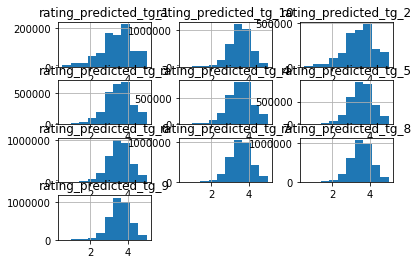

In [104]:
df_rating_test.filter(regex='rating_predicted').hist()
1

In [105]:
prediction_column_suffixes = []
for c in df_rating_test.filter(regex='rating_predicted').columns:
    c = c.replace('rating_predicted', '')
    c = c[1:] if len(c) > 0 else c
    prediction_column_suffixes.append(c)
prediction_column_suffixes

['tg_1',
 'tg_2',
 'tg_3',
 'tg_4',
 'tg_5',
 'tg_6',
 'tg_7',
 'tg_8',
 'tg_9',
 'tg_10']

In [106]:
reload()
df_performance_report = pd.concat([tools.performance_report(df_rating_test, 
                                                           prediction_column_suffix=alg) 
                                  for alg in prediction_column_suffixes]).sort_values('RMSE')
df_performance_report

,Average Score,MAE,RMSE,NRMSE,R2,Std of residuals,Avg of residuals
tg_10,3.429811,0.720734,0.930684,0.271351,0.234087,0.958665,-0.022262
tg_9,3.429811,0.722009,0.932589,0.271907,0.230947,0.965264,-0.020470
tg_8,3.429811,0.724345,0.936515,0.273052,0.224458,0.974848,-0.021558
tg_7,3.429811,0.727989,0.941972,0.274643,0.215394,0.986056,-0.018834
tg_6,3.429811,0.734363,0.951458,0.277408,0.199512,1.000347,-0.016812
tg_5,3.429811,0.743260,0.965094,0.281384,0.176404,1.019860,-0.015508
tg_4,3.429811,0.755797,0.984861,0.287147,0.142320,1.048986,-0.011613
tg_3,3.429811,0.782729,1.025715,0.299059,0.069687,1.088474,-0.000781
tg_2,3.429811,0.821176,1.086555,0.316797,-0.043948,1.137779,0.001489
tg_1,3.429811,0.897274,1.204169,0.351089,-0.282184,1.204146,0.007482


## performance table for copying into Latex

In [107]:
print(df_performance_report.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Average Score &       MAE &      RMSE &     NRMSE &        R2 &  Std of residuals &  Avg of residuals \\
\midrule
tg\_10 &       3.429811 &  0.720734 &  0.930684 &  0.271351 &  0.234087 &          0.958665 &         -0.022262 \\
tg\_9  &       3.429811 &  0.722009 &  0.932589 &  0.271907 &  0.230947 &          0.965264 &         -0.020470 \\
tg\_8  &       3.429811 &  0.724345 &  0.936515 &  0.273052 &  0.224458 &          0.974848 &         -0.021558 \\
tg\_7  &       3.429811 &  0.727989 &  0.941972 &  0.274643 &  0.215394 &          0.986056 &         -0.018834 \\
tg\_6  &       3.429811 &  0.734363 &  0.951458 &  0.277408 &  0.199512 &          1.000347 &         -0.016812 \\
tg\_5  &       3.429811 &  0.743260 &  0.965094 &  0.281384 &  0.176404 &          1.019860 &         -0.015508 \\
tg\_4  &       3.429811 &  0.755797 &  0.984861 &  0.287147 &  0.142320 &          1.048986 &         -0.011613 \\
tg\_3  &       3.429811 &  0.782729 &  1

## Some plots

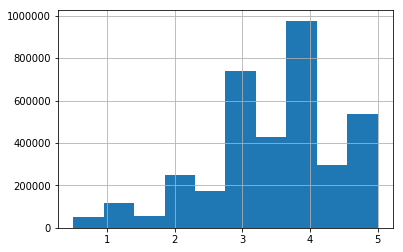

In [108]:
df_rating_test[config.rating_col].hist()

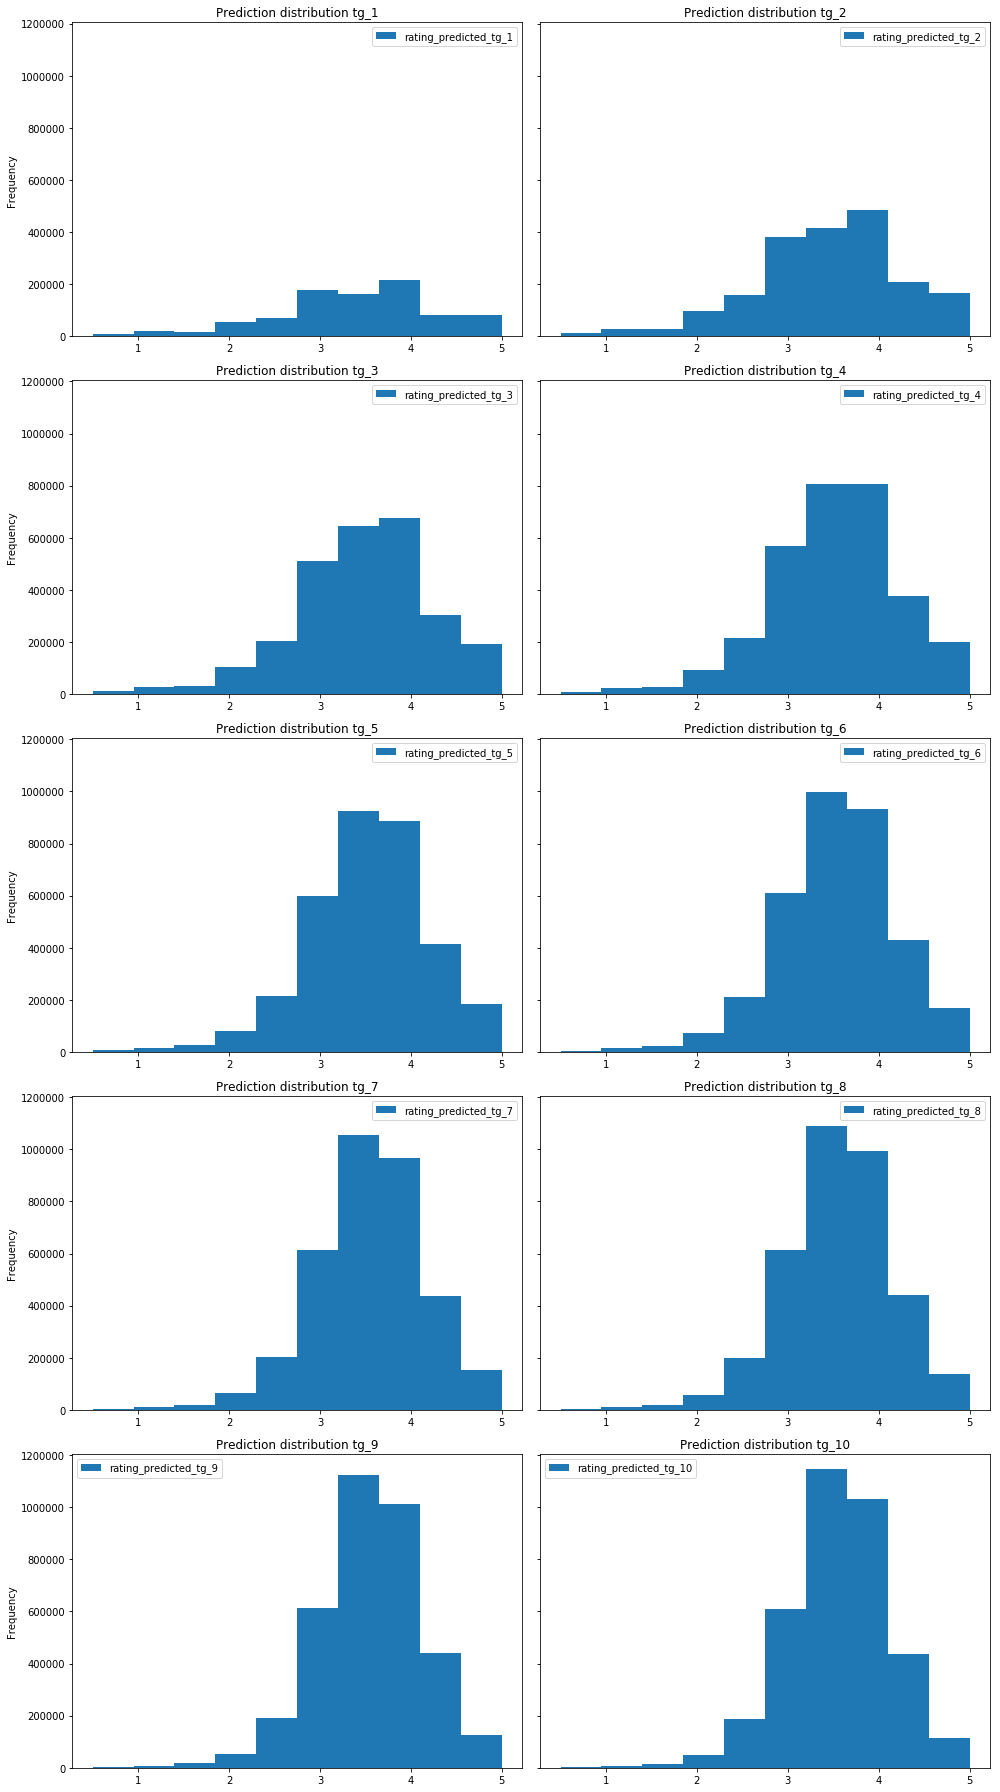

In [109]:
reload()
_ = tools.plot_side_by_side(tools.plot_prediction_histogram,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

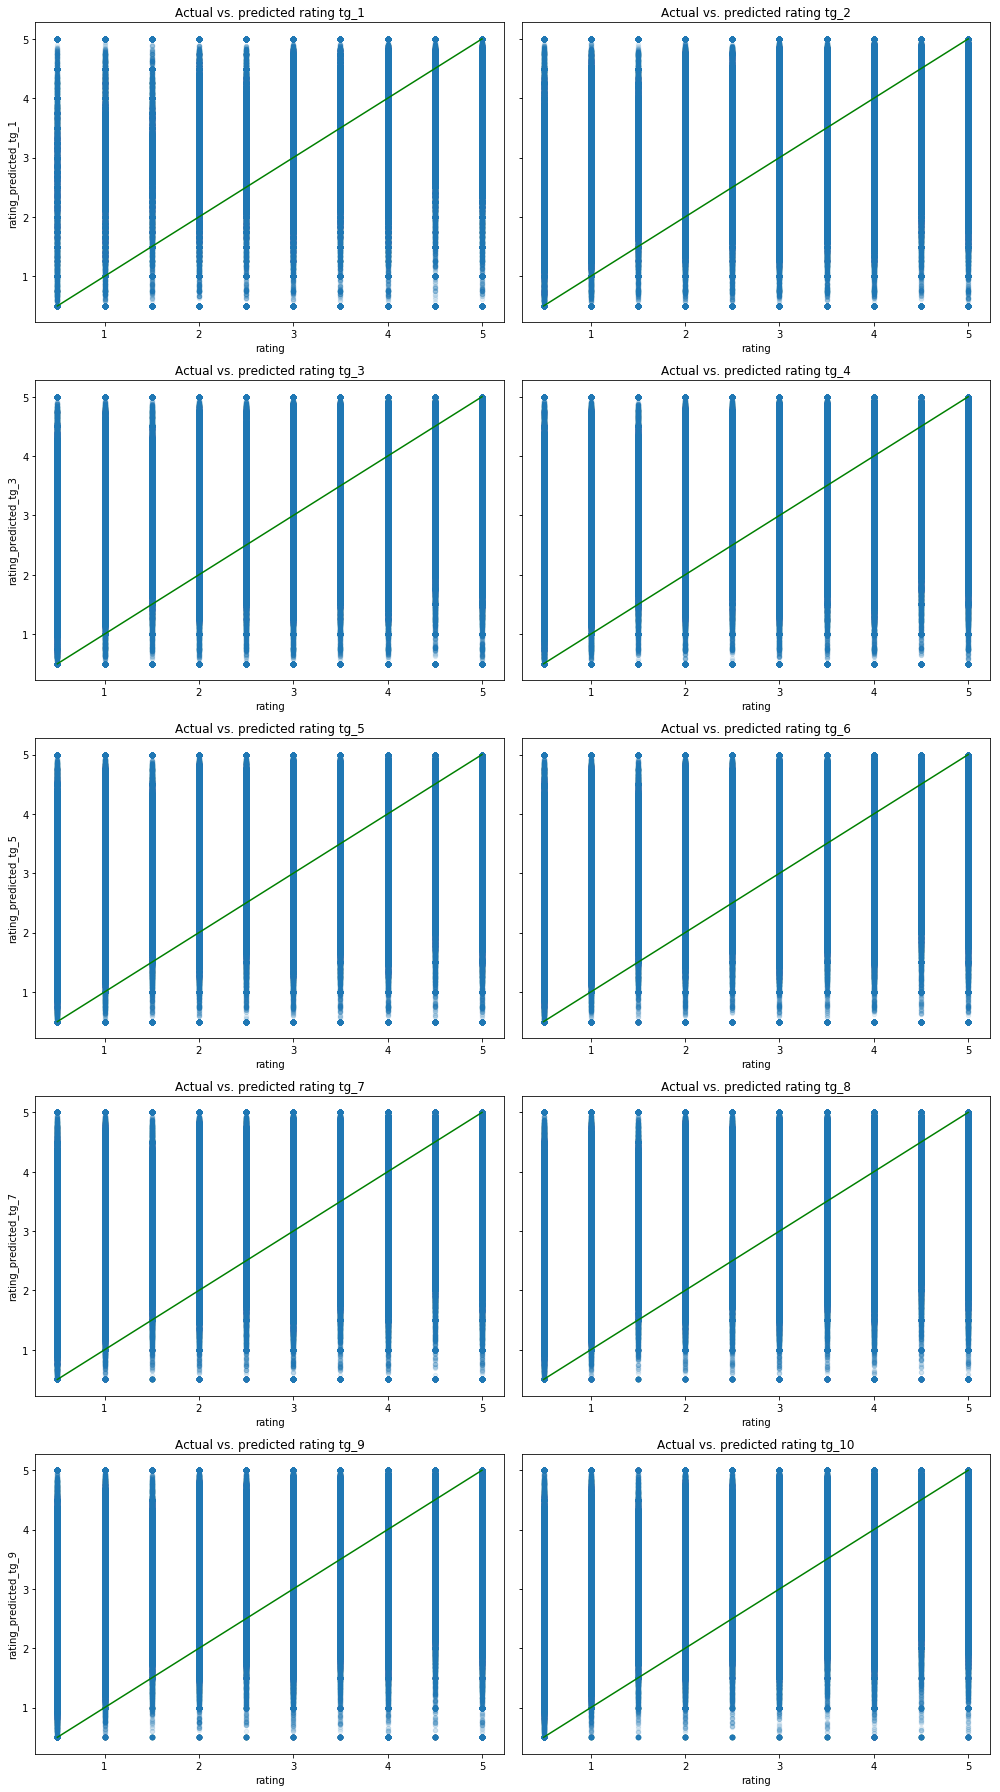

In [110]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_prediction,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes,
                            alpha=.1)

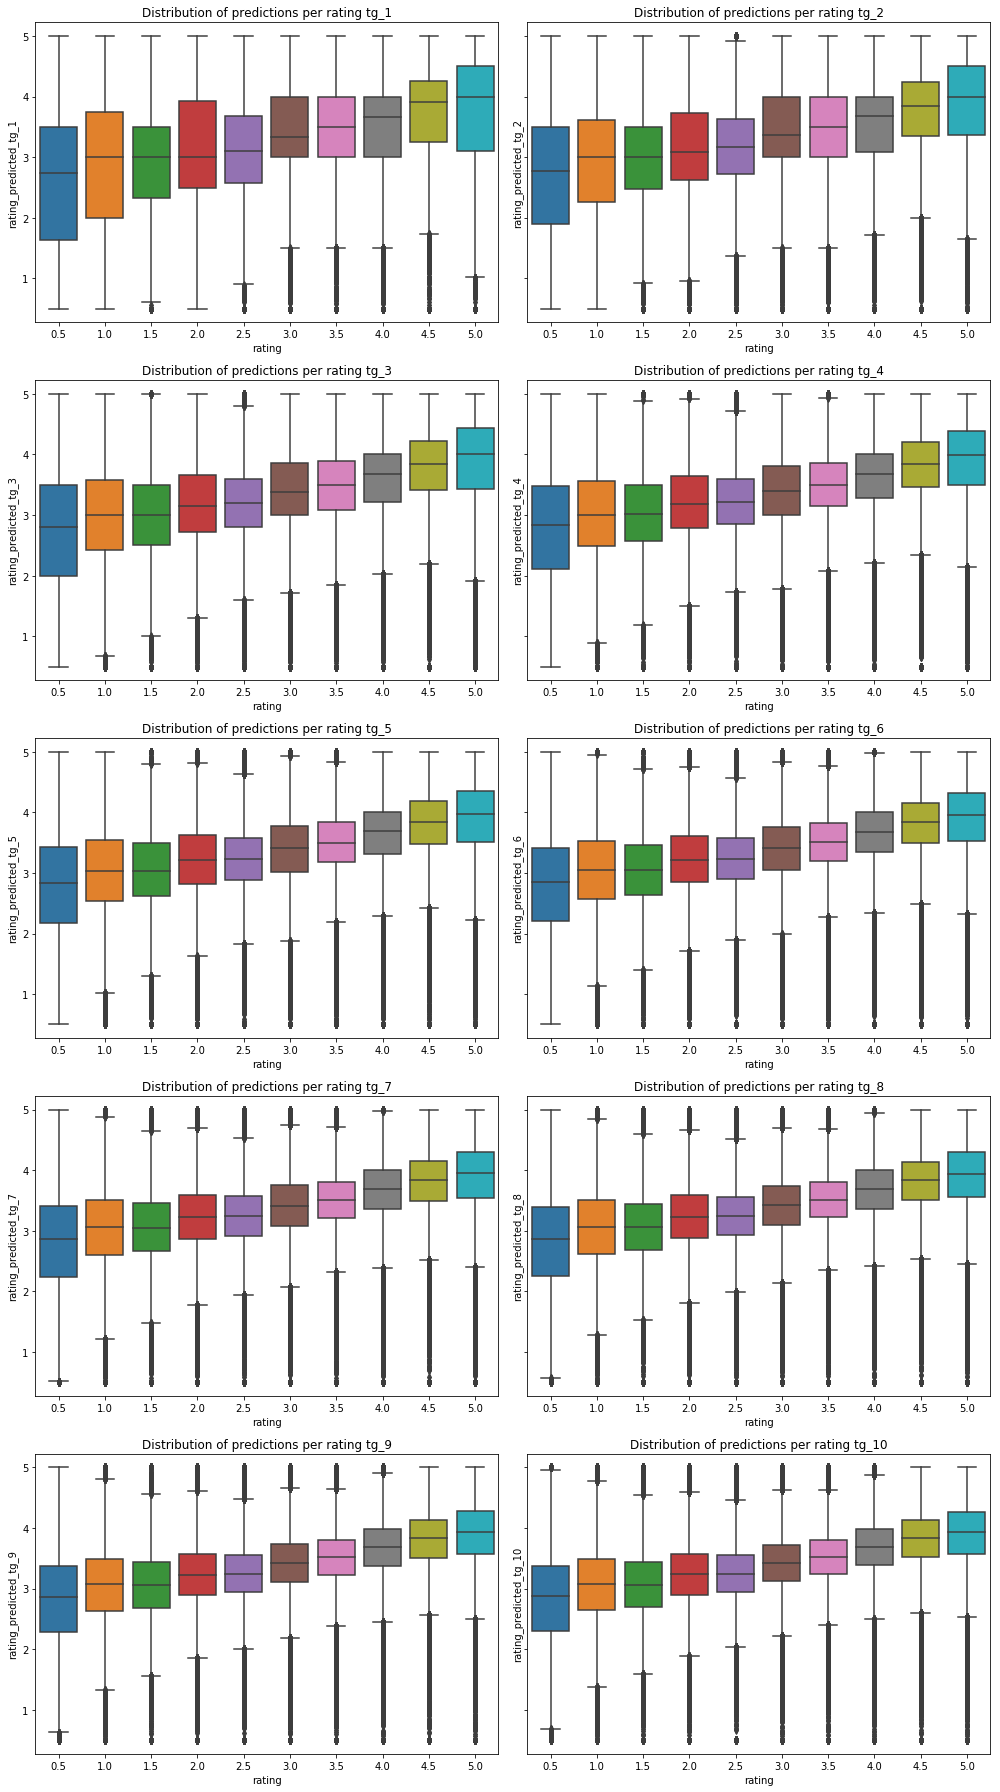

In [111]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

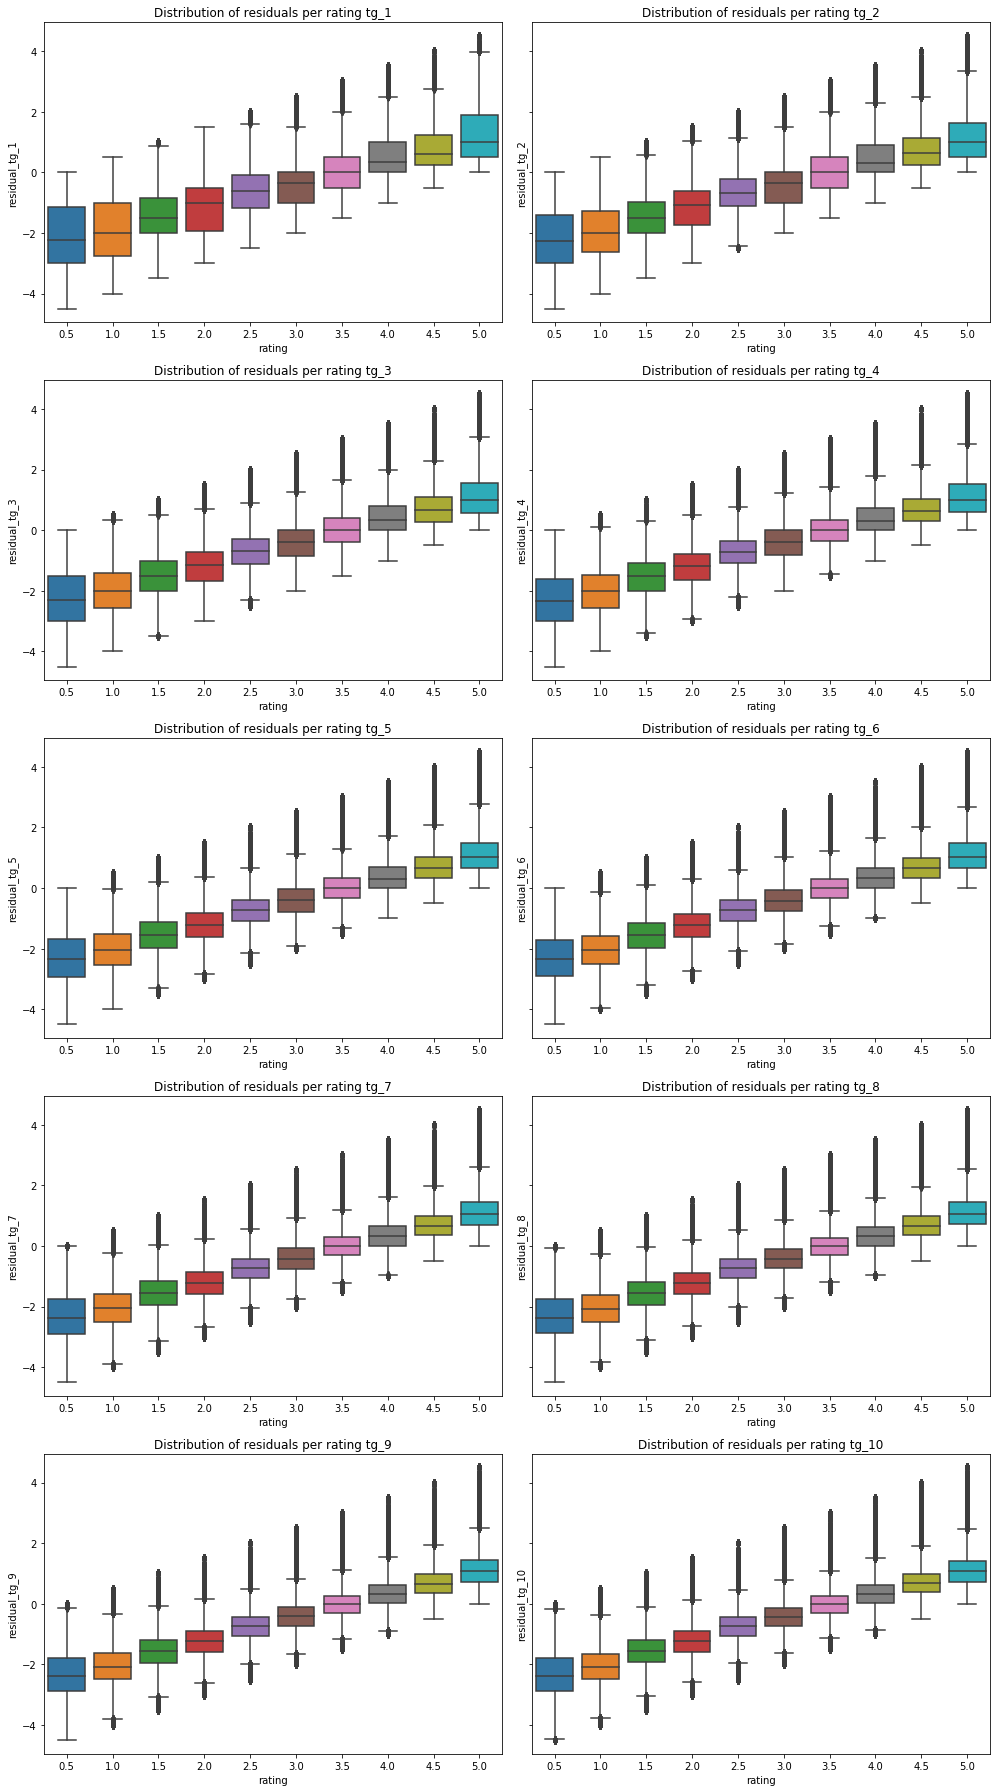

In [112]:
reload()
_ = tools.plot_side_by_side(tools.plot_residual_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

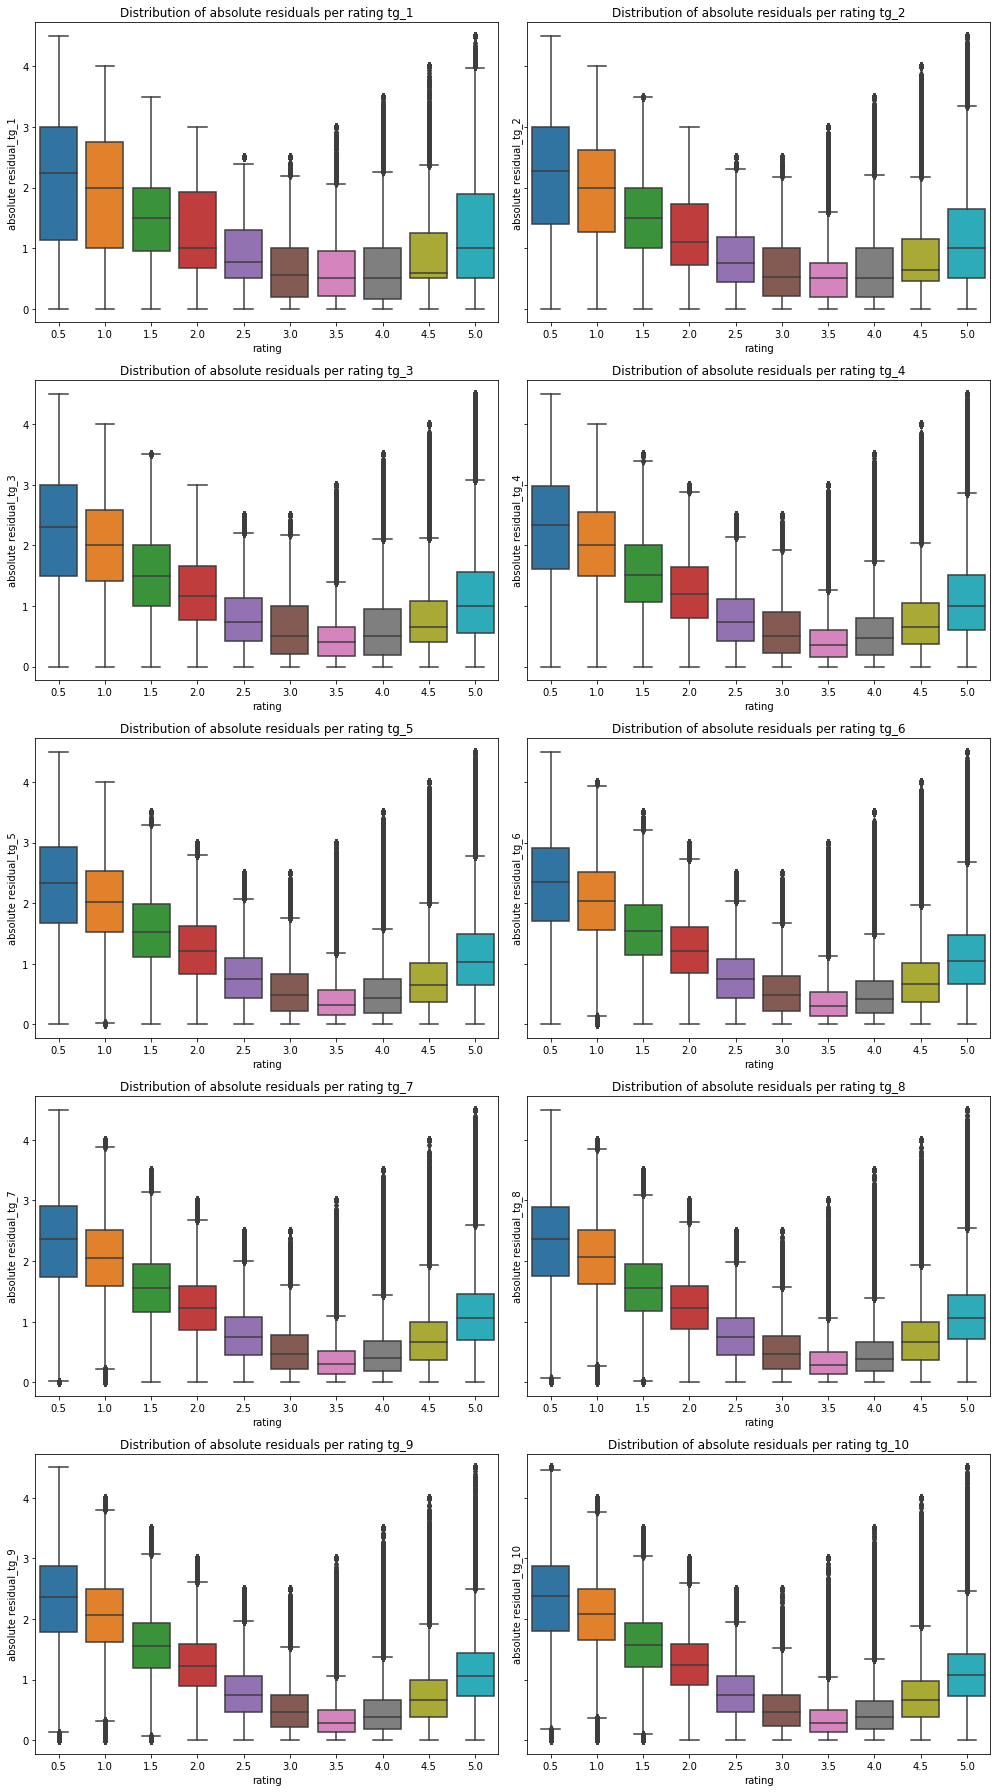

In [113]:
reload()
_ = tools.plot_side_by_side(tools.plot_absolute_residual_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

In [114]:
# reload()
# _ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_violinplot,
#                             df_rating_pred=df_rating_test,
#                             prediction_column_suffixes=prediction_column_suffixes)

# Save the current notebook into results folder and push to the repository

In [115]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [116]:
from notebook import notebookapp
import urllib
import json
import os
import ipykernel

currentTime = lambda : time.strftime('%Y-%m-%d-%H%M')
def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

notebook_dir, notebook_name = os.path.split(notebook_path())
output = os.path.join(notebook_dir, 'output', f'{notebook_name}_{currentTime()}.ipynb')
os.system(f'jupyter nbconvert --to ipynb {notebook_path()} --output {output}')
os.system(f'git add {output}')
os.system(f'git commit -m "result computed on {currentTime()}"')
os.system('git push')

0

In [117]:
df_rating_test.to_csv(os.path.join(notebook_dir, 'output', f'{notebook_name}_{currentTime()}_df_rating_test.csv'))